In [1]:
from math import sqrt
import matplotlib.pyplot as plt
import numpy as np
import sys, os
from sys import argv
import ROOT
from ROOT import TH1F, TCanvas, TFile
import pandas as pd
from dataclasses import make_dataclass
import multiprocessing as mp
import cmath
from array import array

Welcome to JupyROOT 6.22/08


In [5]:
def read_logscan(logfile):
    """This function is used to read logfiles generated by qnFit/sort.sh.
    To read the nll, file id and fit status into a dataframe.

    Args:
        logfile (_type_): _description_

    Returns:
        dataframe: _description_
    """
    # mass: bootstrapping file; id: fit result index; nll: NLL; status;
    one_log = make_dataclass("one_log", [("mass", float), ("id", str), ("nll",float), ("status", str)])
    df1 = pd.DataFrame()
    f1 = open(logfile,"r+")
    for l1 in f1:
        nll_temp = l1.split()[1]
        mass_temp = l1.split()[0].split("//")[1].split("-")[1]
        id_temp = l1.split()[0].split("//")[1].split("-")[2].split(".")[0]
        status_temp = l1.split()[3]
        #df1 = df1.append([one_log(float(mass_temp), str(id_temp), float(nll_temp), str(status_temp))], ignore_index=True)
        df1 = pd.concat([df1, pd.DataFrame([one_log(float(mass_temp),int(id_temp), float(nll_temp), str(status_temp))])], ignore_index=True)
    return df1

In [6]:
# Use pd.groupby and pd.merge to get the id of minimum nll for each bootstrapping sample.
df1 = read_logscan("/disk401/lhcb/qinning/b2dpp_farm10/qnFit/bootstrapping/check_log.txt")
df_converged = df1[df1["status"] == "CONVERGED"]
df_groupby = df_converged[["mass","nll"]].groupby(by="mass")["nll"].min()
df_merge = pd.merge(df_groupby,df_converged,how="left",on=["mass","nll"])
df_merge_firstid = df_merge.groupby(by="mass")["id"].min()
df_merge = pd.merge(df_merge_firstid,df_merge,how="left",on=["mass","id"])
print(df_merge.head())
print(df_merge.shape)

   mass  id      nll     status
0   0.0   2 -11145.9  CONVERGED
1   1.0  14 -11397.4  CONVERGED
2   2.0  24 -11205.3  CONVERGED
3   3.0  31 -11257.6  CONVERGED
4   4.0  40 -10957.2  CONVERGED
(500, 4)


In [8]:
df_merge

mass    id      nll     status
0      0.0     2 -11145.9  CONVERGED
1      1.0    14 -11397.4  CONVERGED
2      2.0    24 -11205.3  CONVERGED
3      3.0    31 -11257.6  CONVERGED
4      4.0    40 -10957.2  CONVERGED
..     ...   ...      ...        ...
495  495.0  4953 -11194.1  CONVERGED
496  496.0  4965 -11115.3  CONVERGED
497  497.0  4976 -11532.4  CONVERGED
498  498.0  4987 -11042.4  CONVERGED
499  499.0  4999 -11198.4  CONVERGED

[500 rows x 4 columns]

In [14]:
title1 = ["SI_{0:02d}".format(i) for i in range(0,12)]
title2 = ["SR_{0:02d}".format(i) for i in range(0,12)]
title3 = ["ar_H0_Fwave","ai_H0_Fwave"]
title = title1 + title2 + title3 + ["bootfile","id"]
df_original = pd.DataFrame(columns=title)
for i in range(0,500):
    temp_id = df_merge[df_merge["mass"]==i]["id"].values[0]
    temp_id = str(temp_id).zfill(4)
    temp_filename = "funcs/fit-"+str(i)+"-"+str(temp_id)+".func"
    temp_file = open(temp_filename,"r+")
    dict_temp = {}
    for line1 in temp_file:
        dict_temp[line1.split()[0]] = line1.split()[2]
    dict_temp["bootfile"] = i
    dict_temp["id"] = temp_id
    df_temp = pd.DataFrame(dict_temp,index=[0])
    df_original = pd.concat([df_original,df_temp],join="inner")
df_original.to_csv("./temp.csv",index=False)

In [15]:
df_original = pd.read_csv("./temp.csv")
for i in range(0,12):
    """ This part, the complex number = H*ci
    df_original["modulus_{0:02d}".format(i)] = np.sqrt(pow(df_original["SR_{0:02d}".format(i)] * df_original["ar_H0_Fwave"] - df_original["SI_{0:02d}".format(i)] * df_original["ai_H0_Fwave"],2) + pow(df_original["SI_{0:02d}".format(i)] * df_original["ar_H0_Fwave"] + df_original["SR_{0:02d}".format(i)] * df_original["ai_H0_Fwave"],2))
    df_original["phase_{0:02d}".format(i)] = 2*np.arctan2((df_original["SI_{0:02d}".format(i)] * df_original["ar_H0_Fwave"] + df_original["SR_{0:02d}".format(i)] * df_original["ai_H0_Fwave"]),df_original["modulus_{0:02d}".format(i)] + df_original["SR_{0:02d}".format(i)] * df_original["ar_H0_Fwave"] - df_original["SI_{0:02d}".format(i)] * df_original["ai_H0_Fwave"] )
    """
    df_original["modulus_{0:02d}".format(i)] = np.sqrt(pow(df_original["SR_{0:02d}".format(i)],2) + pow(df_original["SI_{0:02d}".format(i)],2))
    df_original["phase_{0:02d}".format(i)] = 2*np.arctan2(df_original["SI_{0:02d}".format(i)],df_original["modulus_{0:02d}".format(i)] + df_original["SR_{0:02d}".format(i)] )

#print(df_original.head())
#print(df_original.shape)
df_original.to_csv("./temp_2.csv",index=False)

In [16]:
SI_00= 1.64604e+00   
SI_01=-2.54206e-01
SI_02=-1.68648e-01
SI_03= 0.00000e+00
SI_04= 5.63264e-01
SI_05= 7.96075e-01
SI_06= 6.30183e-01
SI_07= 5.15363e-01
SI_08= 3.76519e-01
SI_09= 3.05665e-01
SI_10= 2.41110e-01
SI_11= 2.76210e-01
SR_00= 1.22291e+00
SR_01= 1.05995e+00
SR_02= 1.04132e+00
SR_03= 1.00000e+00
SR_04= 7.23298e-01
SR_05= 4.32149e-01
SR_06=-5.12977e-02
SR_07=-2.17742e-01
SR_08=-1.76697e-01
SR_09=-9.78286e-02
SR_10=-1.06465e-01
SR_11=-3.99990e-01
ai_H0_Fwave = -1.12716e-01
ar_H0_Fwave = -3.16488e+00  
dict_SI = {}
dict_SR = {}
for i in range(0,12):
    dict_SI["SI_{0:02d}".format(i)] = eval("SI_{0:02d}".format(i))
    dict_SR["SR_{0:02d}".format(i)] = eval("SR_{0:02d}".format(i))
dict_Fwave = {"ai_H0_Fwave":ai_H0_Fwave,"ar_H0_Fwave":ar_H0_Fwave}
dict_all = dict_SI.copy()
dict_all.update(dict_SR)
dict_all.update(dict_Fwave)
dict_all["bootfile"] = -999
dict_all["id"] = -999


In [17]:
#dict_all
df_realvalue = pd.DataFrame(dict_all,index=[0])
for i in range(0,12):
    """ This part, the complex number = H*ci
    df_realvalue["modulus_{0:02d}".format(i)] = np.sqrt(pow(df_realvalue["SR_{0:02d}".format(i)] * df_realvalue["ar_H0_Fwave"] - df_realvalue["SI_{0:02d}".format(i)] * df_realvalue["ai_H0_Fwave"],2) + pow(df_realvalue["SI_{0:02d}".format(i)] * df_realvalue["ar_H0_Fwave"] + df_realvalue["SR_{0:02d}".format(i)] * df_realvalue["ai_H0_Fwave"],2))
    df_realvalue["phase_{0:02d}".format(i)] = 2*np.arctan2((df_realvalue["SI_{0:02d}".format(i)] * df_realvalue["ar_H0_Fwave"] + df_realvalue["SR_{0:02d}".format(i)] * df_realvalue["ai_H0_Fwave"]),df_realvalue["modulus_{0:02d}".format(i)] + df_realvalue["SR_{0:02d}".format(i)] * df_realvalue["ar_H0_Fwave"] - df_realvalue["SI_{0:02d}".format(i)] * df_realvalue["ai_H0_Fwave"] )
    """
    df_realvalue["modulus_{0:02d}".format(i)] = np.sqrt(pow(df_realvalue["SR_{0:02d}".format(i)],2) + pow(df_realvalue["SI_{0:02d}".format(i)],2))
    df_realvalue["phase_{0:02d}".format(i)] = 2*np.arctan2(df_realvalue["SI_{0:02d}".format(i)],df_realvalue["modulus_{0:02d}".format(i)] + df_realvalue["SR_{0:02d}".format(i)] )

df_realvalue.to_csv("./realvalue.csv",index=False)

In [5]:
#for i in range(0,12):
#    mask = df_original["phase_{0:02d}".format(i)]<0
#    df_original.loc[mask,"phase_{0:02d}".format(i)] = df_original.loc[mask,"phase_{0:02d}".format(i)] + 2*np.pi
#    mask2 = df_realvalue["phase_{0:02d}".format(i)]<0
#    df_realvalue.loc[mask2,"phase_{0:02d}".format(i)] = df_realvalue.loc[mask2,"phase_{0:02d}".format(i)] + 2*np.pi
#df_original["phase_00"]

['modulus_00', 'phase_00', 'modulus_01', 'phase_01', 'modulus_02', 'phase_02', 'modulus_03', 'phase_03', 'modulus_04', 'phase_04', 'modulus_05', 'phase_05', 'modulus_06', 'phase_06', 'modulus_07', 'phase_07', 'modulus_08', 'phase_08', 'modulus_09', 'phase_09', 'modulus_10', 'phase_10', 'modulus_11', 'phase_11']


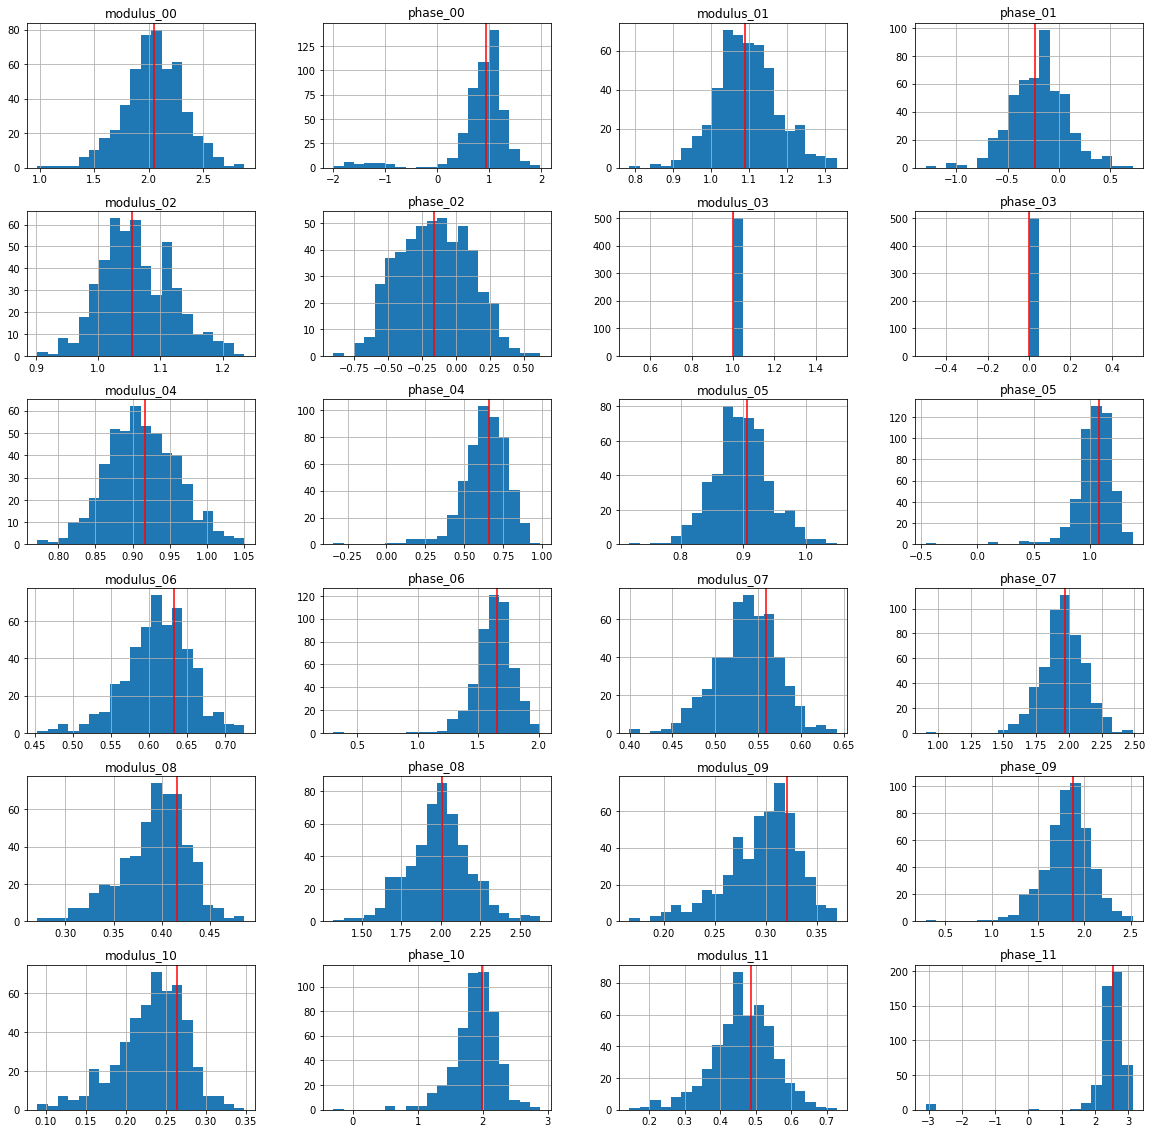

In [18]:
filter_plot = [col for col in df_original.columns if col.startswith('modulus') or col.startswith('phase')]
print(filter_plot)
df_toplot = df_original[filter_plot]
#df_toplot = df_toplot[df_toplot["phase_00"]>-0.5]
plots_Spline = df_toplot.hist(layout=(6,4),sharex=False,sharey=False,figsize=(20,20),bins=20)
for i in range(len(plots_Spline)):
    for j in range(len(plots_Spline[i])):
        plots_Spline[i][j].axvline(df_realvalue[filter_plot[i*len(plots_Spline[i])+j]].values[0],color="red")

In [19]:

ROOT.gStyle.SetOptStat(0)
list_dat = [1.876,1.8766,1.9,1.925,1.95,1.975,2.0,2.1,2.2,2.5,2.8,3.1,3.4,3.416]
h1 = ROOT.TH1F("h1","Modulus(a_{0})",len(list_dat)-1,array('d',list_dat))
h2 = ROOT.TH1F("h2","Phase(#delta_{0})",len(list_dat)-1,array('d',list_dat))
for i in range(len(list_dat)-2):
    #h1.GetXaxis().SetBinLabel(i+1,"{0:.3f}".format(list_dat[i]))
    if i == 3:
        h1.SetBinContent(i+1,1)
        h1.SetBinError(i+1,0)
        h2.SetBinContent(i+1,0.001)
        h2.SetBinError(i+1,0)
    else:
        h1.SetBinContent(i+1,df_realvalue["modulus_{0:02d}".format(i)].values[0])
        h1.SetBinError(i+1,df_toplot["modulus_{0:02d}".format(i)].std())
        h2.SetBinContent(i+1,df_realvalue["phase_{0:02d}".format(i)].values[0])
        h2.SetBinError(i+1,df_toplot["phase_{0:02d}".format(i)].std())

c1 = ROOT.TCanvas("c1","c1",800,600)
h1.Draw()
h1.GetXaxis().SetRangeUser(1.7,3.6)
#c1.SaveAs("modulus.pdf")
#c1.SaveAs("modulus.png")
c2 = ROOT.TCanvas("c2","c2",800,600)
h2.Draw()
h2.GetXaxis().SetRangeUser(1.8,3.6)
l1 = ROOT.TLine(1.75,3.1415,3.8,3.1415)
l2 = ROOT.TLine(1.75,-3.1415,3.4,-3.1415)
l1.SetLineColor(2)
l1.SetLineStyle(2)
l2.SetLineColor(2)
l2.SetLineStyle(2)
#l1.Draw("same")
#l2.Draw("same")
#c2.SaveAs("phase.pdf")
#c2.SaveAs("phase.png")

In [20]:
df_modulus = df_realvalue.filter(regex="modulus")
df_phase = df_realvalue.filter(regex="phase")
df_modulus_err = df_toplot.filter(regex="modulus").std()
df_phase_err = df_toplot.filter(regex="phase").std()

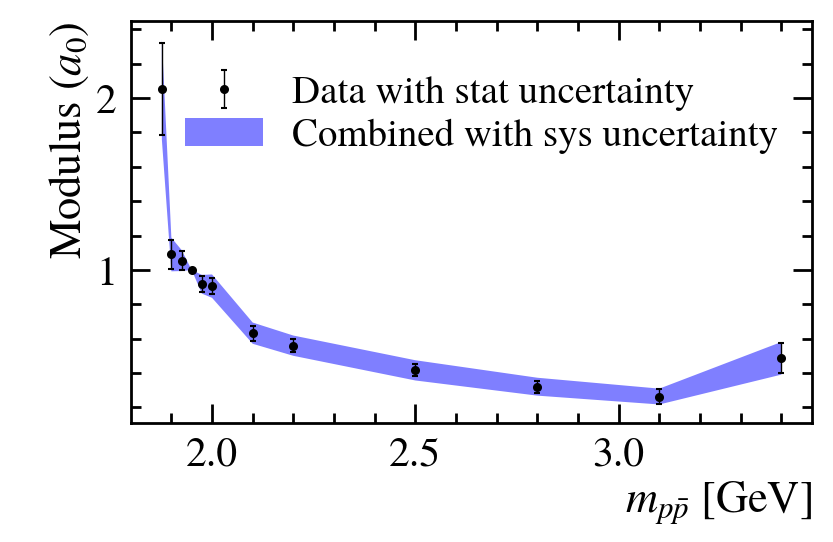

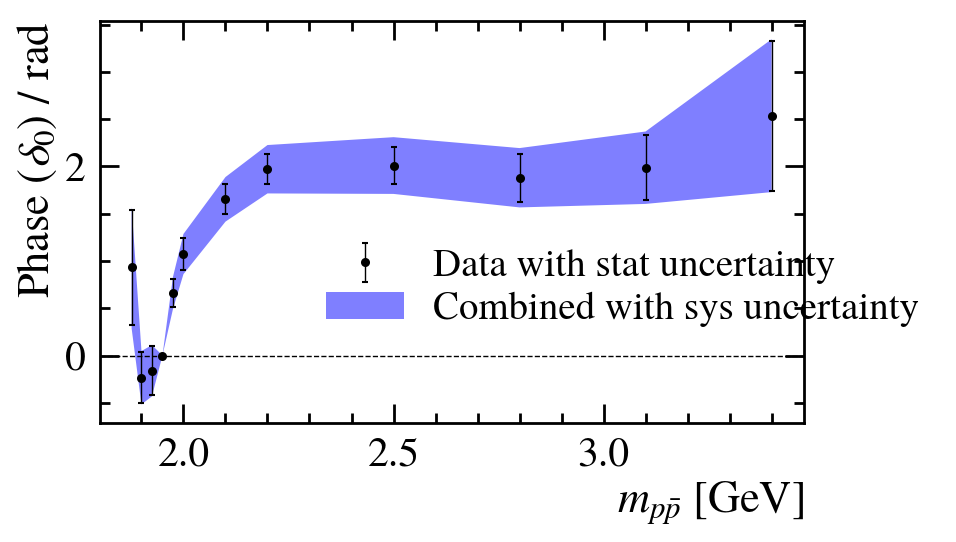

In [26]:
import mplhep as hep
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import pandas as pd
import numpy as np

# Load the data from Pandas dataframes df_modulus and df_phase
list_modulus_values = df_modulus.values[0]
list_modulus_err = df_modulus_err.tolist()
list_phase_values = df_phase.values[0]
list_phase_err = df_phase_err.tolist()

# Define the x-edges of each histogram bin based on the bin centers
list_dat = [1.8766,1.9,1.925,1.95,1.975,2.0,2.1,2.2,2.5,2.8,3.1,3.4]
list_edge = [list_dat[0]-(list_dat[1]-list_dat[0])/2.0]
for i in range(len(list_dat)):
    to_append = list_dat[i]+list_dat[i]-list_edge[i]
    list_edge.append(to_append)

# Set the plotting style using mplhep
hep.style.use(hep.style.LHCb2)

# Create the first histogram of modulus values
fig1,ax1 = plt.subplots(figsize=(11,7)) # Create a new figure and axis
hep.histplot(list_modulus_values,bins=list_edge,yerr=list_modulus_err,ax=ax1,histtype="errorbar",color="black",label="Data with stat uncertainty") # Plot the data as a histogram with error bars
ax1.set_xlabel(r"$m_{p\bar{p}}$ [GeV]") # Set the x-axis label
ax1.set_ylabel(r"Modulus ($a_{0}$)") # Set the y-axis label

# Create the second histogram of phase values
fig2,ax2 = plt.subplots(figsize=(11,7)) # Create a new figure and axis
hep.histplot(list_phase_values,bins=list_edge,yerr=list_phase_err,ax=ax2,histtype="errorbar",color="black",label="Data with stat uncertainty") # Plot the data as a histogram with error bars
ax2.set_xlabel(r"$m_{p\bar{p}}$ [GeV]") # Set the x-axis label
ax2.set_ylabel(r"Phase ($\delta_{0}$) / rad") # Set the y-axis label

# Load additional data from CSV files and calculate systematic uncertainties
list_df_demp = []
path_1 = "/disk401/lhcb/qinning/b2dpp_farm10/uncertainties/"
path_2 = "/qnFit/FitRnd/spline.csv"
list_file = [
    path_1+"fixed_states"+path_2,
    path_1+"background_fraction"+path_2,
    path_1+"Blatt-Weisskopf"+path_2,
]

for i in list_file:
    df_temp = pd.read_csv(i)
    list_df_demp.append(df_temp)
df_spline = pd.concat(list_df_demp,axis=0,ignore_index=True)

lamb_maxAbs = lambda x: max(x.min(),x.max(),key=abs)
df_spline_new = np.abs(df_spline.apply(lamb_maxAbs))

list_phase_sys = df_spline_new.filter(regex="phase").tolist()
list_modulus_sys = df_spline_new.filter(regex="modulus").tolist()

# Add systematic uncertainties to the histograms
list_modulus_upper = [list_modulus_values[i]+np.sqrt(list_modulus_err[i]**2+list_modulus_sys[i]**2) for i in range(len(list_modulus_values))]
list_modulus_lower = [list_modulus_values[i]-np.sqrt(list_modulus_err[i]**2+list_modulus_sys[i]**2) for i in range(len(list_modulus_values))]
list_phase_upper = [list_phase_values[i]+np.sqrt(list_phase_err[i]**2+list_phase_sys[i]**2) for i in range(len(list_phase_values))]
list_phase_lower = [list_phase_values[i]-np.sqrt(list_phase_err[i]**2+list_phase_sys[i]**2) for i in range(len(list_phase_values))]
ax1.fill_between(list_dat,list_modulus_upper,list_modulus_lower,alpha=0.5,color="blue",edgecolor="none") # Fill the area between the upper and lower bounds with a translucent color
ax2.fill_between(list_dat,list_phase_upper,list_phase_lower,alpha=0.5,color="blue",edgecolor="none") # Fill the area between the upper and lower bounds with a translucent color
error_patch = mpatches.Patch(facecolor='blue', alpha=0.5, label='Combined with sys uncertainty',edgecolor='none')
ax2.axhline(y=0.0,linestyle="dashed",color="black",linewidth=1.0) # Add a horizontal line at y=0.0

# Add the combined legend to both histograms
ax1.legend(handles=ax1.get_legend_handles_labels()[0] + [error_patch], labels=ax1.get_legend_handles_labels()[1] + [error_patch.get_label()], frameon=False)
ax2.legend(handles=ax2.get_legend_handles_labels()[0] + [error_patch], labels=ax2.get_legend_handles_labels()[1] + [error_patch.get_label()], frameon=False,loc=(0.3,0.2))
fig1.savefig("modulus.pdf")
fig2.savefig("phase.pdf")

#plt.show()

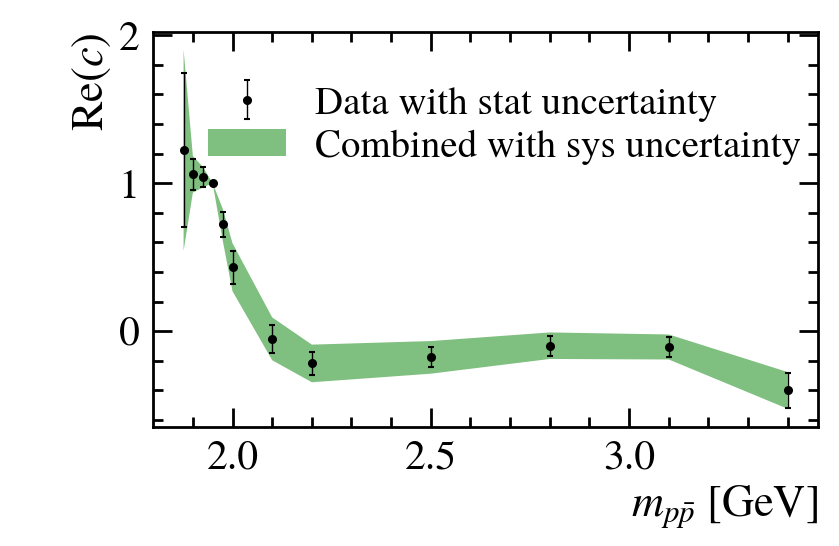

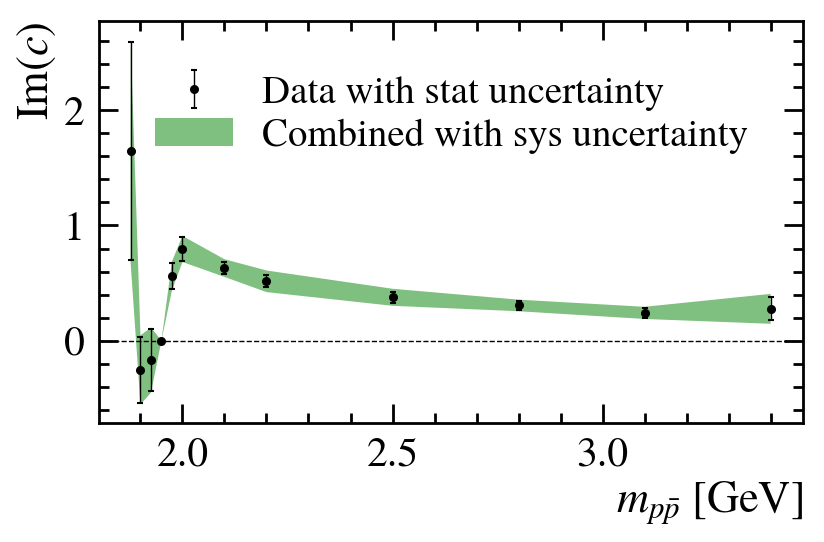

In [28]:
df_real = df_original.filter(regex="SR")
list_real_err = df_real.std().to_list()
list_real_values = df_realvalue.filter(regex="SR").values[0]
df_imag = df_original.filter(regex="SI")
list_imag_err = df_imag.std().to_list()
list_imag_values = df_realvalue.filter(regex="SI").values[0]

list_dat = [1.8766,1.9,1.925,1.95,1.975,2.0,2.1,2.2,2.5,2.8,3.1,3.4]
list_edge = [list_dat[0]-(list_dat[1]-list_dat[0])/2.0]
for i in range(len(list_dat)):
    to_append = list_dat[i]+list_dat[i]-list_edge[i]
    list_edge.append(to_append)

hep.style.use(hep.style.LHCb2)
fig1,ax1 = plt.subplots(figsize=(11,7)) # Create a new figure and axis
hep.histplot(list_real_values,bins=list_edge,yerr=list_real_err,ax=ax1,histtype="errorbar",color="black",label="Data with stat uncertainty") # Plot the data as a histogram with error bars
ax1.set_xlabel(r"$m_{p\bar{p}}$ [GeV]") # Set the x-axis label
ax1.set_ylabel(r"Re($c$)") # Set the y-axis label
fig2,ax2 = plt.subplots(figsize=(11,7)) # Create a new figure and axis
hep.histplot(list_imag_values,bins=list_edge,yerr=list_imag_err,ax=ax2,histtype="errorbar",color="black",label="Data with stat uncertainty") # Plot the data as a histogram with error bars
ax2.set_xlabel(r"$m_{p\bar{p}}$ [GeV]") # Set the x-axis label
ax2.set_ylabel(r"Im($c$)") # Set the y-axis label

list_df_temp = []
path_1 = "/disk401/lhcb/qinning/b2dpp_farm10/uncertainties/"
path_2 = "/qnFit/FitRnd/spline.csv"
list_file = [
    path_1+"fixed_states"+path_2,
    path_1+"background_fraction"+path_2,
    path_1+"Blatt-Weisskopf"+path_2,
]
for i in list_file:
    df_temp = pd.read_csv(i)
    list_df_demp.append(df_temp)
df_spline = pd.concat(list_df_demp,axis=0,ignore_index=True)
lamb_maxAbs = lambda x: max(x.min(),x.max(),key=abs)
df_spline_new = np.abs(df_spline.apply(lamb_maxAbs))
list_real_sys = df_spline_new.filter(regex="SR").tolist()
list_imag_sys = df_spline_new.filter(regex="SI").tolist()
list_real_upper = [list_real_values[i]+np.sqrt(list_real_err[i]**2+list_real_sys[i]**2) for i in range(len(list_real_values))]
list_real_lower = [list_real_values[i]-np.sqrt(list_real_err[i]**2+list_real_sys[i]**2) for i in range(len(list_real_values))]
list_imag_upper = [list_imag_values[i]+np.sqrt(list_imag_err[i]**2+list_imag_sys[i]**2) for i in range(len(list_imag_values))]
list_imag_lower = [list_imag_values[i]-np.sqrt(list_imag_err[i]**2+list_imag_sys[i]**2) for i in range(len(list_imag_values))]
ax1.fill_between(list_dat,list_real_upper,list_real_lower,alpha=0.5,color="green",edgecolor="none") # Fill the area between the upper and lower bounds with a translucent color
ax2.fill_between(list_dat,list_imag_upper,list_imag_lower,alpha=0.5,color="green",edgecolor="none") # Fill the area between the upper and lower bounds with a translucent color
error_patch = mpatches.Patch(facecolor='green', alpha=0.5, label='Combined with sys uncertainty',edgecolor='none')
ax2.axhline(y=0.0,linestyle="dashed",color="black",linewidth=1.0) # Add a horizontal line at y=0.0
ax1.legend(handles=ax1.get_legend_handles_labels()[0] + [error_patch], labels=ax1.get_legend_handles_labels()[1] + [error_patch.get_label()], frameon=False)
ax2.legend(handles=ax2.get_legend_handles_labels()[0] + [error_patch], labels=ax2.get_legend_handles_labels()[1] + [error_patch.get_label()], frameon=False)
fig1.savefig("Real_c.pdf")
fig2.savefig("Imag_c.pdf")

In [34]:
df_realvalue.filter(regex="SR").values[0]

array([ 1.22291  ,  1.05995  ,  1.04132  ,  1.       ,  0.723298 ,
        0.432149 , -0.0512977, -0.217742 , -0.176697 , -0.0978286,
       -0.106465 , -0.39999  ])